In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pickle 
import random 
from collections import Counter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(220);

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device = }')

device = 'cuda'


In [4]:
with open('words_250000_train.txt', 'r', encoding='utf-8') as f:
    text = f.read().splitlines()

In [5]:
random.shuffle(text)
text[:10]

['thyreohyal',
 'verdancy',
 'nonbolshevism',
 'norml',
 'consecrating',
 'ginhound',
 'yaffed',
 'beats',
 'squarechinned',
 'skiagraphic']

In [6]:
BLOCK_SIZE = max(len(words) for words in text)
print(f'{BLOCK_SIZE = }')

BLOCK_SIZE = 29


In [7]:
charset = sorted(list(set(''.join(text))))
stoi = {c:idx+2 for idx,c in enumerate(charset)}
itos = {idx+2:c for idx,c in enumerate(charset)}
stoi['.'] = 1
itos[1] = '.'
stoi[''] = 0
itos[0] = ''
encode = lambda x: [stoi[i] for i in x] 
decode = lambda x: ''.join([itos[i] for i in x])
VOCAB_SIZE = len(stoi)
print(f'{VOCAB_SIZE = }') 

VOCAB_SIZE = 28


In [8]:
def padding(x):
    x = F.pad(x, (0, (BLOCK_SIZE - x.size()[0])), value=0)
    return x

In [9]:
def build_dataset(words):
    x = []
    y = []
    for word in words:
        encoded = torch.tensor(encode(word))
        input = torch.ones_like(encoded)
        x.append(input) 
        sorted_letter_count = Counter(word).most_common()
        g = [0]*26
        prev = torch.clone(x[-1])
        while not torch.all(prev != 1):
            prev = torch.clone(x[-1])
            for letter, _ in sorted_letter_count:
                idx = ord(letter) - ord('a')
                if g[idx] != 1:
                    g[idx] = 1
                    g_in = stoi[letter]
                    break
            y.append(g_in)
            idxs = torch.where(encoded == g_in)[0]
            prev[idxs] = g_in 
            if torch.any(prev == 1):
                x.append(prev)
            
    # adding paddding to every input 
    x = pad_sequence(x, batch_first=True, padding_value=0)
    x = F.pad(x, (0, (BLOCK_SIZE - x.size()[1])), value=0)
    y = torch.tensor(y, dtype=torch.long)

    return x,y 

random.shuffle(text)
n1 = int(0.9*len(text))
n2 = int(0.95*len(text))

Xtr, Ytr = build_dataset(text[:n1])
Xval, Yval = build_dataset(text[n1:n2])
Xts, Yts  = build_dataset(text[n2:])

# Xtr, Ytr = load_split('train')
# Xval, Yval = load_split('val')
# Xts, Yts = load_split('test')

In [10]:
print(f'Train Shape : {Xtr.shape} {Ytr.shape}')
print(f'Val Shape : {Xval.shape} {Yval.shape}')
print(f'Test Shape : {Xts.shape} {Yts.shape}')

Train Shape : torch.Size([1513547, 29]) torch.Size([1513547])
Val Shape : torch.Size([83830, 29]) torch.Size([83830])
Test Shape : torch.Size([83832, 29]) torch.Size([83832])


In [107]:
# hyperparemters 
LEARNING_RATE = 1e-4
N_EMBD = 32
HEAD_SIZE = 16
BATCH_SIZE = 32
EPOCHS = 100000

In [31]:
def get_batch(split):
    X, Y  = {'train': (Xtr, Ytr),
            'val' : (Xval, Yval)}[split]
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE,))
    xb, yb = X[ix].to(device), Y[ix].to(device)
    return xb, yb


@torch.no_grad()
def split_loss():
    model.eval()
    out = {}
    for split in ['train','val']:
        losses = torch.zeros(200)
        for k in range(200):
            xb, yb = get_batch(split)
            logits, loss = model(xb,yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [51]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        
    def forward(self, x):
        B,T,C = x.shape
        idx_k = torch.where(x == 1)[0]
        idx_q = torch.where(x != 1)[0]
        k = self.key(x) # (B,T,C) 
        q = self.query(x) # (B,T,C)
        # k[idx_k, :] = 0
        # q[idx_q, :] = 0
        
        # compute attention scores ('affinities')        
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B,T,C) @ (B,C,T) --> (B,T,T)
        # wei = wei.masked_fill(wei[:,:T,:T] == 0, float('-inf'))"
        wei = F.softmax(wei, dim=-1) # (B,T,T)
        # nan_mask = torch.isnan(wei)
        
        # # Set NaN values to 0
        # wei[nan_mask] = 0

        # perform the weighted aggregation of values 
        v = self.value(x)
        out = wei @ v # (B,T,T) @ (B,T,C) --> (B,T,C)
        return out 

In [96]:
class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = Head(HEAD_SIZE)
        self.ln = nn.LayerNorm(HEAD_SIZE)

    def forward(self, x):
        x = self.ln(self.sa(x))
        return x 

In [97]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embd = nn.Embedding(VOCAB_SIZE, N_EMBD) # B, T, C 
        self.pos_embd = nn.Embedding(BLOCK_SIZE, N_EMBD)
        self.block = Block()
        self.ln = nn.LayerNorm(N_EMBD)
        self.output = nn.Linear(HEAD_SIZE*BLOCK_SIZE, VOCAB_SIZE)

    def forward(self, x, target = None):
        B, T = x.shape
        tok = self.token_embd(x) # B, T, C
        pos = self.pos_embd(torch.arange(BLOCK_SIZE,device=device))
        x = tok + pos
        x = self.ln(x)
        x = self.block(x)
        x = x.view(B, -1)
        logits = self.output(x) # B, vocab_size
        
        if target is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, target)
            
        return logits, loss  

    def guess(self, context, guessed_letters):
        with torch.no_grad():
            context = context.view(1,-1)
            logits, _ = self(context)
            probs = F.softmax(logits, dim=-1)
            ix = torch.argmax(probs).item()
            while guessed_letters[ix-2] == 1:
                ix = torch.multinomial(probs, num_samples=1).item()
            return ix  

    def play(self, word, verbose=False):
        input = torch.tensor([1] * len(word))
        encoded = encode(word)
        context = padding(input).to(device)
        chances = 6
        guessed_letters = [0]*26 
        while chances > 0:
            ix = self.guess(context, guessed_letters)
            guessed_letters[ix-2] = 1 
            idx = np.where(np.array(encoded) == ix)[0]
            if idx.size != 0:
                context[idx] = ix
            else:
                chances -= 1
            w = np.array(context.view(-1).cpu())
            if verbose == True:
                print(f'Guessed --- {itos[ix]} for Context {decode(w)}', end='\n') 
            if decode(w) == word:
                return 1
        return 0

In [98]:
model = Model()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
num_params = sum(p.numel() for p in model.parameters(recurse=True))
num_params

16476

In [108]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [109]:
lossi_1 = []
lossi_2 = []
ud = []
# lri = []
# lre = torch.linspace(-4, 0, 1000)
# lrs = 10**lre

In [110]:
for epoch in range(EPOCHS):
    if epoch % 10000 == 0:
        loss = split_loss()
        print(f"step {epoch}: train loss {loss['train']:.4f}, val loss {loss['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    
    # for name, p in model.named_parameters():
    #     p.retain_grad = True

    optimizer.zero_grad(set_to_none=True)
    lossi_2.append(loss.item())
    loss.backward()
    optimizer.step()
    # with torch.no_grad(): 
    #     ud.append([(LEARNING_RATE*p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()]) 
    # # break
loss = split_loss()
print(f"step {EPOCHS}: train loss {loss['train']:.4f}, val loss {loss['val']:.4f}")

step 0: train loss 2.2830, val loss 2.3277
step 10000: train loss 2.2811, val loss 2.2947
step 20000: train loss 2.2678, val loss 2.2912
step 30000: train loss 2.2909, val loss 2.2680
step 40000: train loss 2.2606, val loss 2.2793
step 50000: train loss 2.2567, val loss 2.2855
step 60000: train loss 2.2710, val loss 2.2768
step 70000: train loss 2.2767, val loss 2.2500
step 80000: train loss 2.2422, val loss 2.2545
step 90000: train loss 2.2365, val loss 2.2665
step 100000: train loss 2.2604, val loss 2.2418


------------------------------------- MODEL PERFORMANCE ---------------------------------

1. token embedding + output layer: (30k)

   train_loss = 2.67, val_loss = 2.69 
2. token embedding + hidden layer + tanh + output: (85k)

    train_loss : 2.60, val_loss = 2.62 
3. token embedding + hidden layer + ReLU + output: (85K) (1e-3)
   
    train_loss : 2.53, val_loss = 2.55

4. token embedding + pos embedding + self head attention + layer Norm + output = (16k) (1e-3)
 
    train_loss : 2.3801, val_loss = 2.3589


------------------------------------------- GRAPHS --------------------------------------------

In [64]:
def activations_plot():
    plt.figure(figsize=(20,4))
    legends = []
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, Tanh) or isintance(layer, ReLU):
            t = layer.out.cpu()
            print('layer %d (%10s) : mean%+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach()) 
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('activation distribution')

# activations_plot() 

In [105]:
def grad_2_data_ratio():
    plt.figure(figsize=(20,6))
    legends = []
    for i, (name, p) in enumerate(list(model.named_parameters())[:-2]):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append(f'params: {name}')
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3
    plt.legend(legends) 

# grad_2_data_ratio()

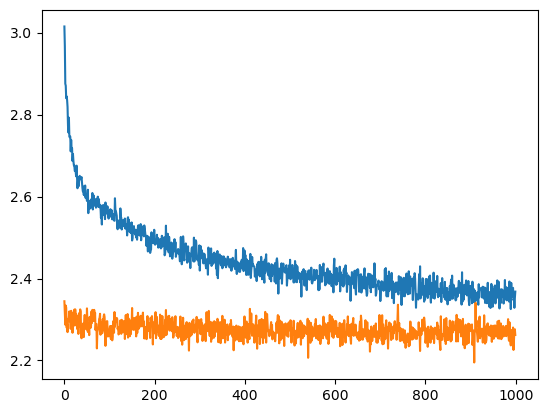

In [111]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(dim=1))
plt.plot(torch.tensor(lossi_2).view(-1,100).mean(dim=1))
plt.show()


------------------------------------ INFERENCE --------------------------------------------------

In [130]:
m.play('hangman', verbose=True)

Guessed --- a for Context .a...a.
Guessed --- l for Context .a...a.
Guessed --- d for Context .a...a.
Guessed --- g for Context .a.g.a.
Guessed --- b for Context .a.g.a.
Guessed --- m for Context .a.gma.
Guessed --- j for Context .a.gma.
Guessed --- t for Context .a.gma.
Guessed --- k for Context .a.gma.


0

In [113]:
# !pip install nltk
# import nltk 
# nltk.download('words')
from nltk.corpus import words

In [114]:
def generate_random_words(num_words):
    # Get a list of English words using the words module from NLTK
    english_words = words.words()
    
    # Initialize an empty list to store the generated random words
    random_word_list = []

    # Iterate to generate the specified number of random words
    for i in range(num_words):
        # Use random.sample to obtain a random word from the English words list
        sample = random.sample(english_words, 1)[0]
        random_word_list.append(sample)
    # Return the list of generated random words
    return random_word_list

In [115]:
english_words = generate_random_words(1000)
english_words = [w.lower() for w in english_words]

In [116]:
wins = 0 

In [117]:
for i in english_words:
    wins += m.play(i)

In [118]:
win_per = (wins / len(english_words))*100
print(f'{win_per:.4f} %')

16.4000 %


In [119]:
model_path = 'simple_model.pth'

# Save the model
torch.save(m.state_dict(), model_path)